# Basket strategy for base 

- Based on `07-base-weight-by-tvl.ipynb`
- The first deployed candidate

# Set up

Set up Trading Strategy data client.


In [ ]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


No existing Trading Strategy configuration found in /Users/moo/.tradingstrategy/settings.json. Starting interactive setup.
Using Trading Strategy requires you to have an API key.


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "08-base-candidate-1-equal-weight"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.base
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 13  # How many assets our basket can hold once
    allocation = 0.97  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 25.0  # Don't make buys less than this amount
    min_volatility_threshold = 0.02  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.50 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0010  # Close position / do not open if weight is less than 10 BPS
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 200_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 12, 10)
    initial_cash = 10_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import filter_scams


#: Assets used in routing and buy-and-hold benchmark values for our strategy, but not traded by this strategy.
SUPPORTING_PAIRS = [
    (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
    (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913",  # USDC on Base 
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    print("Universe is (including benchmark pairs):")
    for idx, pair in enumerate(strategy_universe.iterate_pairs()):
        benchmark = pair.other_data.get("benchmark")
        print(f"   {idx + 1}. pair #{pair.internal_id}: {pair.base.token_symbol} - {pair.quote.token_symbol} ({pair.exchange_name}), {'benchmark/routed token' if benchmark else 'traded token'}")

    return strategy_universe


# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 67 pairs to trade on base for categories {'Meme'}
After scam filter we have 60 pairs
Scammy pair SKIPEPE - WETH, risk score 0.0, pool 0x2822671fc59f03de8402383753111ff06d2d7a64, token 0xb9a5f238dc61eebe820060226c8143cd24624771
Scammy pair DOGESON - WETH, risk score 0.0, pool 0xe5a119820dfa92c6431d73d940fdb3c4b2c565ab, token 0xc48cddc6f2650bdb13dcf6681f61ba07209b5299
Scammy pair GUAN - USDC, risk score 25.0, pool 0x77c1b9db1197b5d9145036aef1221ac17b8e4a54, token 0xcc0adb6c436eb1f65b2f27733bf926691b94c5f1
Scammy pair OSAK - WETH, risk score 25.0, pool 0xcfa7c4bb565915f1c4f9475e2a0536d31efad776, token 0xbfd5206962267c7b4b4a8b3d76ac2e1b2a5c4d5e
Scammy pair CAW - WETH, risk score 25.0, pool 0x110751cbf035862f59a10528dd54b9ac2b048906, token 0xdfbea88c4842d30c26669602888d746d30f9d60d
Scammy pair NYA - WETH, risk score nan, pool 0x783b62afd1d3a82956e8306e787210f1e2a1213a, token 0x38f9bf9dce51833ec7f03c9dc218197999999999
Scammy pai

Loading TVL/liquidity data for 60 pairs:   0%|          | 0/60 [00:00<?, ?it/s]

Universe is (including benchmark pairs):
   1. pair #4569519: DEGEN - WETH (uniswap-v3), traded token
   2. pair #4912540: AIXBT - USDC (uniswap-v3), traded token
   3. pair #4933784: SIMMI - WETH (uniswap-v3), traded token
   4. pair #4762108: LUM - WETH (uniswap-v3), traded token
   5. pair #3746592: WETH - USDC (uniswap-v2), benchmark/routed token
   6. pair #4834635: ANON - WETH (uniswap-v3), traded token
   7. pair #4703496: cbBTC - WETH (uniswap-v3), benchmark/routed token
   8. pair #4573559: BRETT - WETH (uniswap-v3), traded token
   9. pair #4186481: MIGGLES - WETH (uniswap-v2), traded token
   10. pair #3862696: SKI - WETH (uniswap-v2), traded token
   11. pair #4683036: PEPE - WETH (uniswap-v3), traded token
   12. pair #4933380: FAI - WETH (uniswap-v3), traded token
   13. pair #3767188: KEYCAT - WETH (uniswap-v2), traded token
   14. pair #4910380: VADER - WETH (uniswap-v3), traded token
   15. pair #4568627: TOSHI - WETH (uniswap-v3), traded token
   16. pair #3998441: AE

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 60 assets
Category trading pairs 58
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std


@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume

    # Turn to a series of lists
    series = mask.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    series = mask.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(
    dependencies=[volume_inclusion_criteria, volatility_inclusion_criteria, tvl_inclusion_criteria], 
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:       
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp
    
    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)
    
    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,             
        },
    )    

    # 
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #
    
    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series, 
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,         
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])        
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)
    return union_criteria


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    return series.apply(len)


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


# Display indicators diagnostics table
indicators_debug_df = indicators.get_diagnostics()
print(f"We have {len(indicators_debug_df)} indicators:")
def replace_comma_with_newline(text):
    # print(text)
    if isinstance(text, str):        
        return text.replace(',', '<br>')
    return text
indicators_debug_df = indicators_debug_df.map(replace_comma_with_newline)
display(HTML(indicators_debug_df.to_html(escape=False)))


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
)

We have 18 indicators:


,Order,Source,Parameters,Dependencies
Name,,,,
mean_returns,1,close_price,rebalance_volalitity_bars,
rolling_cumulative_volume,1,ohlcv,rolling_volume_bars,
rolling_liquidity_avg,1,close_price,rolling_volume_bars,
trading_pair_count,1,strategy_universe,,
trailing_sharpe,1,close_price,trailing_sharpe_bars,
tvl,1,tvl,,
volatility,1,close_price,rebalance_volalitity_bars,
volatility_ewm,1,close_price,rebalance_volalitity_bars,
trailing_sharpe_ewm,2,dependencies_only_per_pair,trailing_sharpe_bars ewm_span,trailing_sharpe


Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mean_returns, roll…

Using indicator cache /Users/moo/.cache/indicators/base_1h_60_2024-02-13-2024-12-10_ff


Calculating indicators trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mean_returns, rolling…

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [6]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2024-04-06 20:00:00 - 2024-12-10 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [7]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        volatility = indicators.get_indicator_value(
            "volatility",
            pair=pair,
        )
        
        weight = volatility

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1
        if volatility > max_vol[0]:
            max_vol = (volatility, pair)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_equal)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mean_returns, roll…

Using indicator cache /Users/moo/.cache/indicators/base_1h_60_2024-02-13-2024-12-10_ff


  0%|          | 0/21355200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 8989 trades


# Positions at the end

Some example positions at the end


In [8]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position NPC, value 10753.255302671487 USD
Position AI, value 492.1433097051872 USD
Position KEYCAT, value 16256.980124874633 USD
Position FLOPPA, value 6680.83029210347 USD
Position BOOMER, value 7395.262636668668 USD
Position PEPE, value 16998.681399793684 USD
Position LUCKY, value 1459.0858229434587 USD
Position AIXBT, value 134.59345967023953 USD
Position SKI, value 20470.34732668755 USD
Position CATE, value 3364.772954398102 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [9]:
messages = state.visualisation.get_messages_tail(5)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


,0
2024-12-09 20:00:00,"Cycle: #1483 Rebalanced: 👍 Open/about to open positions: 10 Max position value change: 1,839.76 USD Rebalance threshold: 25.00 USD Trades decided: 6 Pairs total: 60 Pairs meeting inclusion criteria: 48 Pairs meeting volume inclusion criteria: 60 Pairs meeting volatility inclusion criteria: 51 Signals created: 48 Total equity: 150,204.11 USD Cash: 65,162.84 USD Investable equity: 145,697.99 USD Accepted investable equity: 84,040.27 USD Allocated to signals: 84,040.27 USD Discarted allocation because of lack of lit liquidity: 120,526.38 USD Rebalance volume: 0.00 USD WETH volatility: 0.007362740494106712 Most volatility pair: SKICAT-WETH Most volatility pair vol: 0.3321767363699701 Most volatility pair signal value: - Most volatility pair signal weight: - Top signal pair: toby-WETH Top signal volatility: 0.024345469884767306 Top signal value: 0.02227233206662763 Top signal weight: 1 Top signal weight (normalised): 0.01 % (got 0.05 % of asked size) Signals with flag capped_by_pool_size: 10 Signals with flag individual_trade_size_too_small: 7"
2024-12-09 16:00:00,"Cycle: #1482 Rebalanced: 👍 Open/about to open positions: 10 Max position value change: 2,788.38 USD Rebalance threshold: 25.00 USD Trades decided: 8 Pairs total: 60 Pairs meeting inclusion criteria: 48 Pairs meeting volume inclusion criteria: 60 Pairs meeting volatility inclusion criteria: 52 Signals created: 48 Total equity: 148,501.55 USD Cash: 66,151.35 USD Investable equity: 144,046.50 USD Accepted investable equity: 83,362.13 USD Allocated to signals: 83,362.13 USD Discarted allocation because of lack of lit liquidity: 118,712.73 USD Rebalance volume: 0.00 USD WETH volatility: 0.00738694535818612 Most volatility pair: SKICAT-WETH Most volatility pair vol: 0.3319470986260447 Most volatility pair signal value: - Most volatility pair signal weight: - Top signal pair: toby-WETH Top signal volatility: 0.02448050719529631 Top signal value: 0.022609316106199498 Top signal weight: 1 Top signal weight (normalised): 0.01 % (got 0.05 % of asked size) Signals with flag capped_by_pool_size: 10 Signals with flag individual_trade_size_too_small: 5"
2024-12-09 12:00:00,"Cycle: #1481 Rebalanced: 👍 Open/about to open positions: 10 Max position value change: 2,072.56 USD Rebalance threshold: 25.00 USD Trades decided: 6 Pairs total: 60 Pairs meeting inclusion criteria: 48 Pairs meeting volume inclusion criteria: 60 Pairs meeting volatility inclusion criteria: 52 Signals created: 48 Total equity: 150,075.26 USD Cash: 69,919.71 USD Investable equity: 145,573.00 USD Accepted investable equity: 83,988.95 USD Allocated to signals: 83,988.95 USD Discarted allocation because of lack of lit liquidity: 120,389.13 USD Rebalance volume: 0.00 USD WETH volatility: 0.007403570089739497 Most volatility pair: SKICAT-WETH Most volatility pair vol: 0.3317872401516761 Most volatility pair signal value: - Most volatility pair signal weight: - Top signal pair: toby-WETH Top signal volatility: 0.02460981678992757 Top signal value: 0.022860117184993596 Top signal weight: 1 Top signal weight (normalised): 0.01 % (got 0.05 % of asked size) Signals with flag capped_by_pool_size: 10 Signals with flag individual_trade_size_too_small: 7"
2024-12-09 08:00:00,"Cycle: #1480 Rebalanced: 👍 Open/about to open positions: 10 Max position value change: 1,203.26 USD Rebalance threshold: 25.00 USD Trades decided: 7 Pairs total: 60 Pairs meeting inclusion criteria: 48 Pairs meeting volume inclusion criteria: 60 Pairs meeting volatility inclusion criteria: 52 Signals created: 48 Total equity: 156,346.73 USD Cash: 70,458.44 USD Investable equity: 151,656.32 USD Accepted investable equity: 86,486.89 USD Allocated to signals: 86,486.89 USD Discarted allocation because of lack of lit liquidity: 127,069.83 USD Rebalance volume: 0.00 USD WETH volatility: 0.007414604631311458 Most volatility pair: SKICAT-WETH Most volatility pair vol: 0.33172513535438364 Most volatility pair signal value: - Most volatility pai

# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [10]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

df = format_signals(alpha_model)
print(f"Chosen signals ({len(df)})")
display(df)

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

Chosen signals (13)


,Signal,Asked size,Accepted size,Value adjust USD,Weights (raw),Weights (norm/cap),Old weight,Flipping,TVL,Flags
Pair,,,,,,,,,,
SPX-WETH,0.017562,12069.203610,23.962736,23.962736,1,0.000285,0.000000,none -> spot,2396,"capped_by_pool_size, individual_trade_size_too..."
NPC-WETH,0.019118,14813.273672,10754.004705,125.275157,1,0.127963,0.124983,no flip,1075400,capped_by_pool_size
AI-WETH,0.020517,15125.525130,488.360756,-3.782553,1,0.005811,0.005787,no flip,48836,"capped_by_pool_size, individual_trade_size_too..."
PEPE-WETH,0.020949,16987.696411,16987.696411,-1098.498878,1,0.202138,0.212676,no flip,3503549,
CATE-WETH,0.021234,13995.114684,3359.047850,-5.725105,1,0.039970,0.039566,no flip,335905,"capped_by_pool_size, individual_trade_size_too..."
toby-WETH,0.022272,11207.537352,5.875992,5.875992,1,0.000070,0.000000,none -> spot,588,"capped_by_pool_size, individual_trade_size_too..."
LUCKY-WETH,0.028910,19120.227791,1458.819911,-26.591229,1,0.017359,0.017467,no flip,145882,capped_by_pool_size
KEYCAT-WETH,0.041821,16251.460852,16251.460852,-1839.757780,1,0.193377,0.212735,no flip,2431568,
BOOMER-WETH,0.044955,18282.895380,7397.574045,386.390378,1,0.088024,0.082444,no flip,739757,capped_by_pool_size


All signals (13)


,Signal,Asked size,Accepted size,Value adjust USD,Weights (raw),Weights (norm/cap),Old weight,Flipping,TVL,Flags
Pair,,,,,,,,,,
TRUMP-USDC,0.007816,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
DOG-WETH,0.009452,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
FEG-WETH,0.010280,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
BRETT-WETH,0.013278,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
$mfer-WETH,0.015391,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
DEGEN-WETH,0.015850,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
BITCOIN-WETH,0.016204,-,NaN,0.000000,0.0,0.000000,0.000000,none -> spot,0,
SPX-WETH,0.017562,12069.20361,23.962736,23.962736,1.0,0.000285,0.000000,none -> spot,2396,"capped_by_pool_size, individual_trade_size_too..."
NPC-WETH,0.019118,14813.273672,10754.004705,125.275157,1.0,0.127963,0.124983,no flip,1075400,capped_by_pool_size


# Equity curve

- Equity curve shows how your strategy accrues value over time

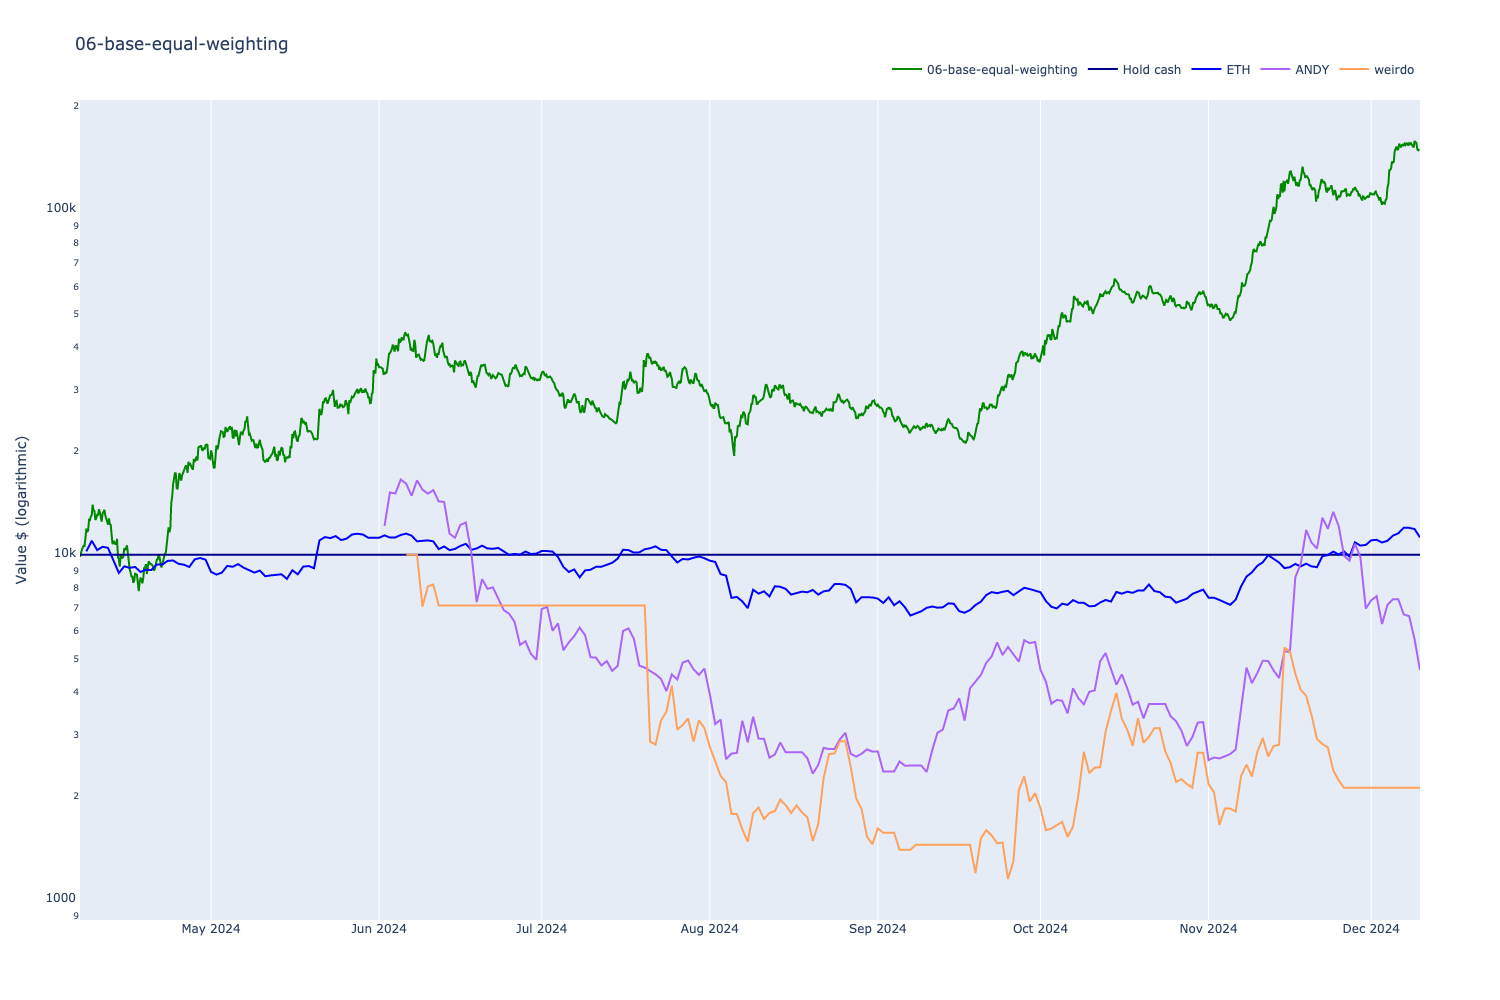

In [11]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "ANDY", "weirdo"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

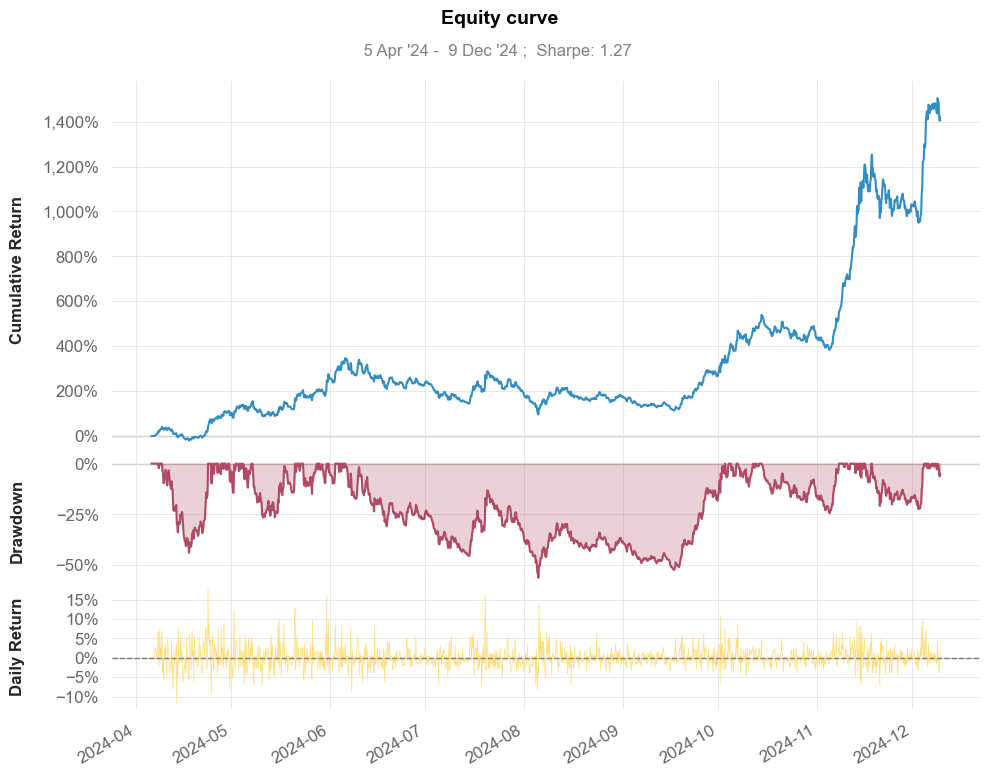

In [12]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Available pairs

- Number of pairs available to trade every month



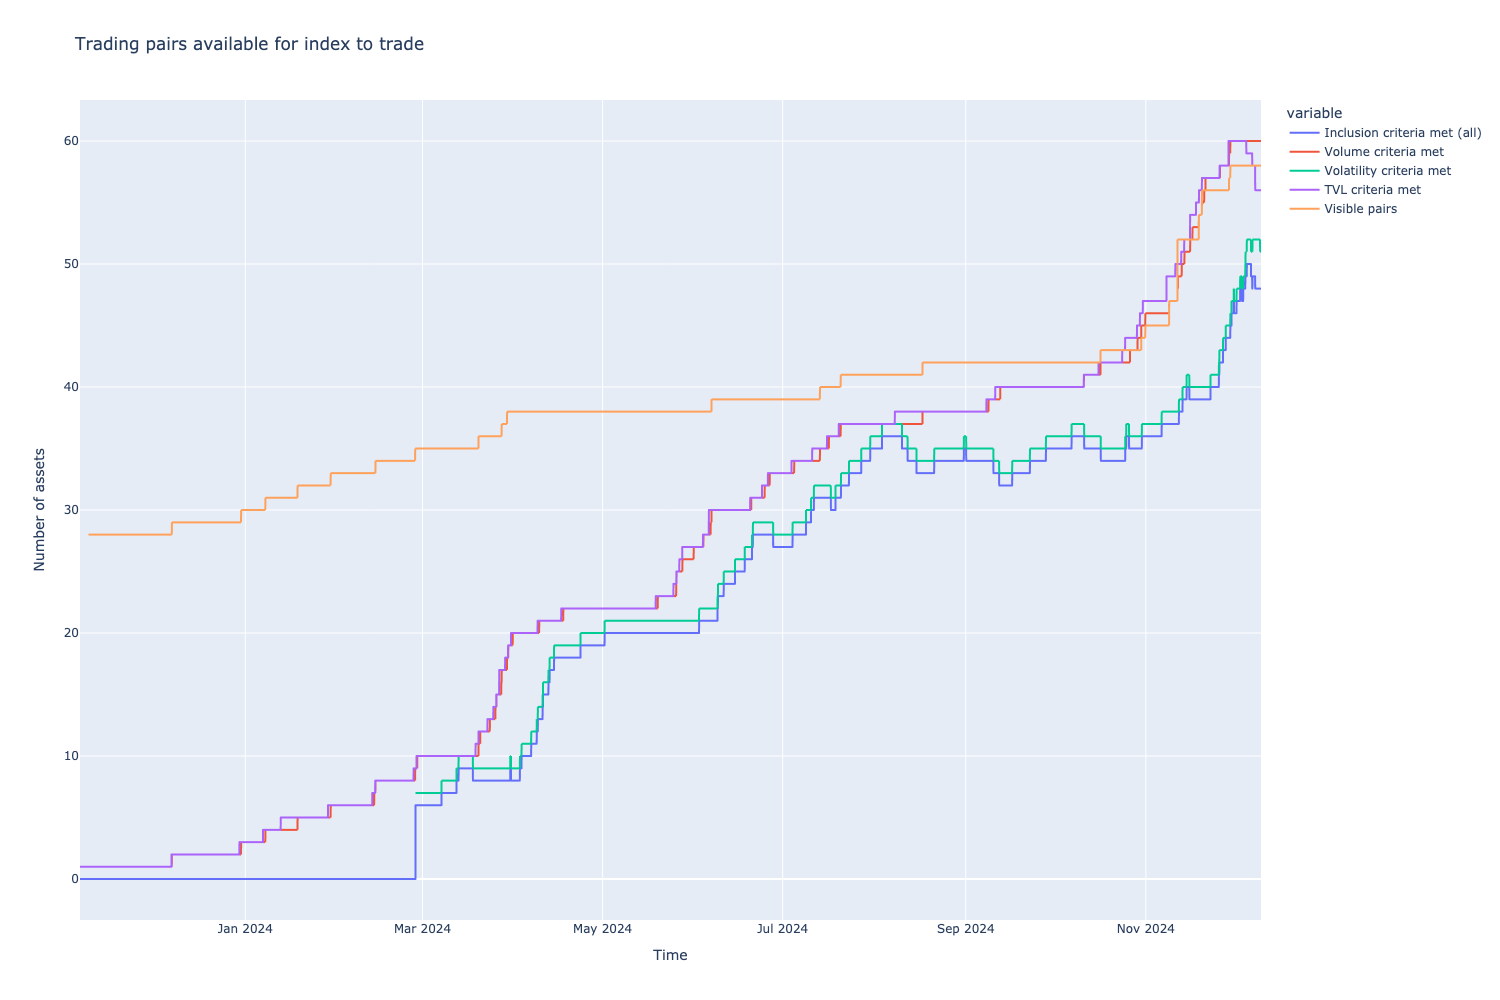

,Inclusion criteria met (all),Volume criteria met,Volatility criteria met,TVL criteria met,Visible pairs
2024-12-08 19:00:00,48,60.0,52.0,56,58.0
2024-12-08 20:00:00,48,60.0,52.0,56,58.0
2024-12-08 21:00:00,48,60.0,52.0,56,58.0
2024-12-08 22:00:00,48,60.0,52.0,56,58.0
2024-12-08 23:00:00,48,60.0,52.0,56,58.0
2024-12-09 00:00:00,48,60.0,52.0,56,58.0
2024-12-09 01:00:00,48,60.0,52.0,56,58.0
2024-12-09 02:00:00,48,60.0,52.0,56,58.0
2024-12-09 03:00:00,48,60.0,52.0,56,58.0
2024-12-09 04:00:00,48,60.0,52.0,56,58.0


In [13]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

# Indicator values



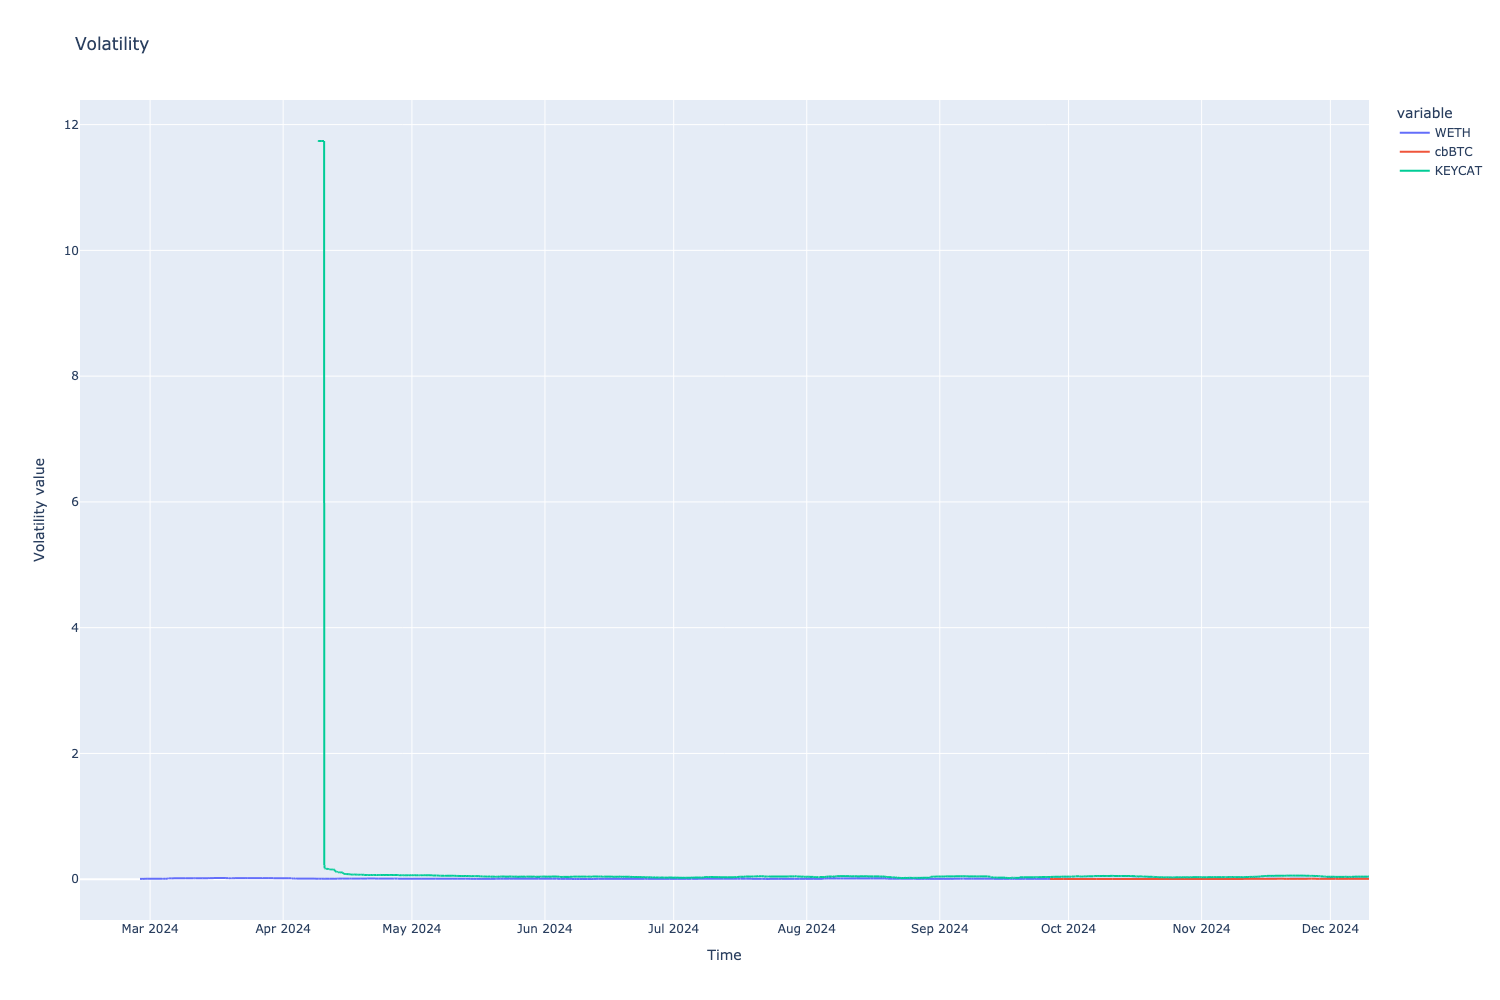

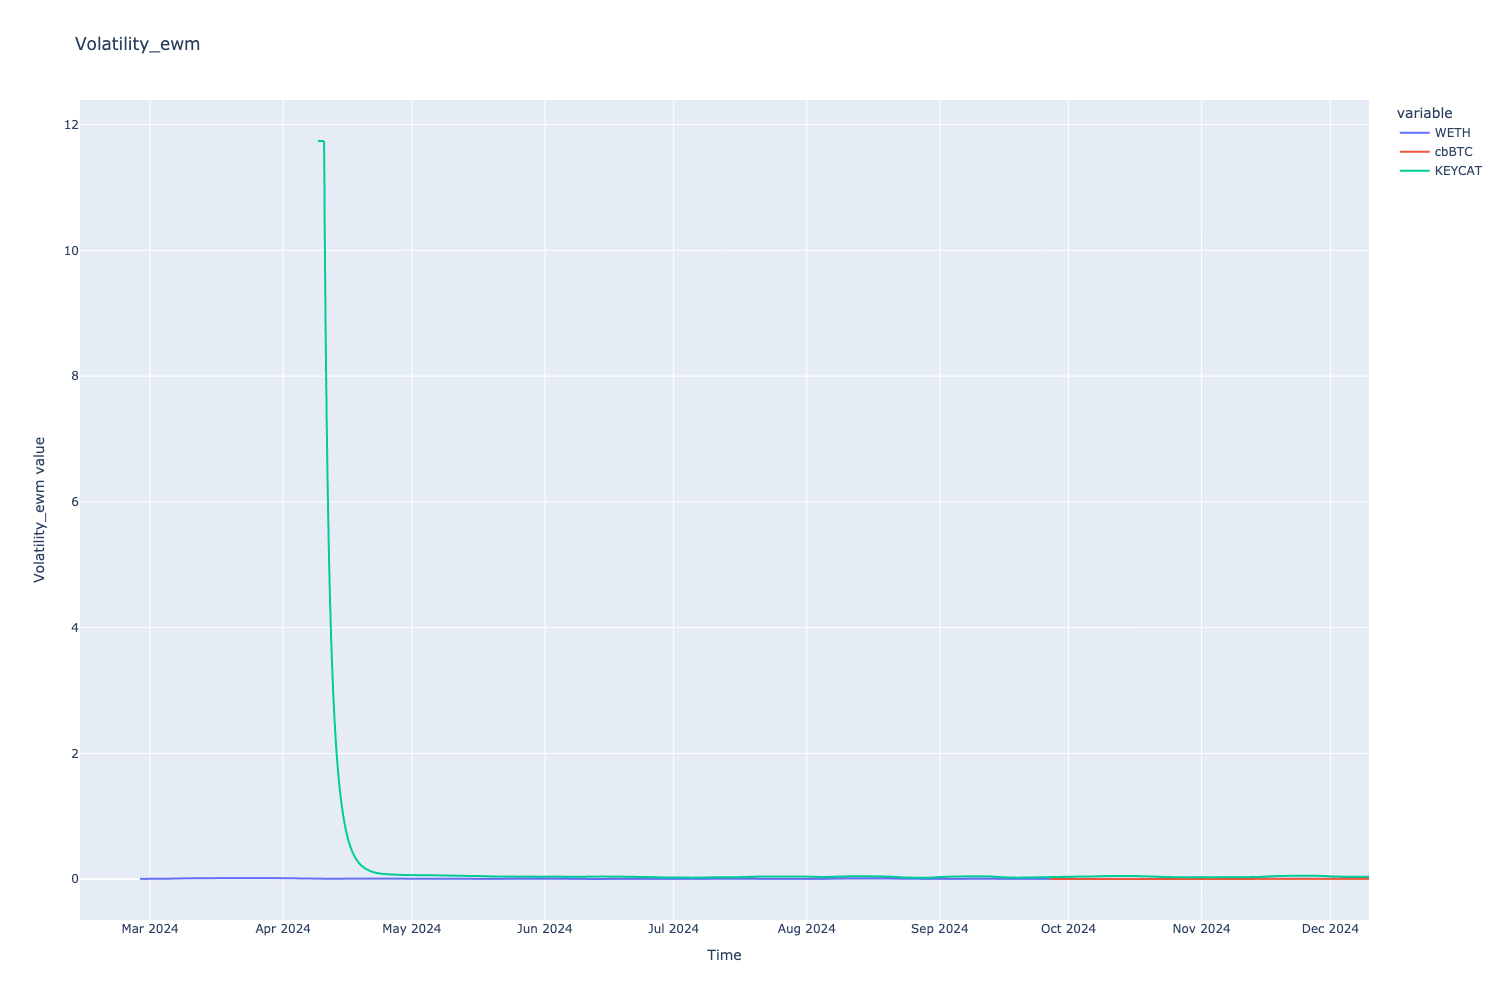

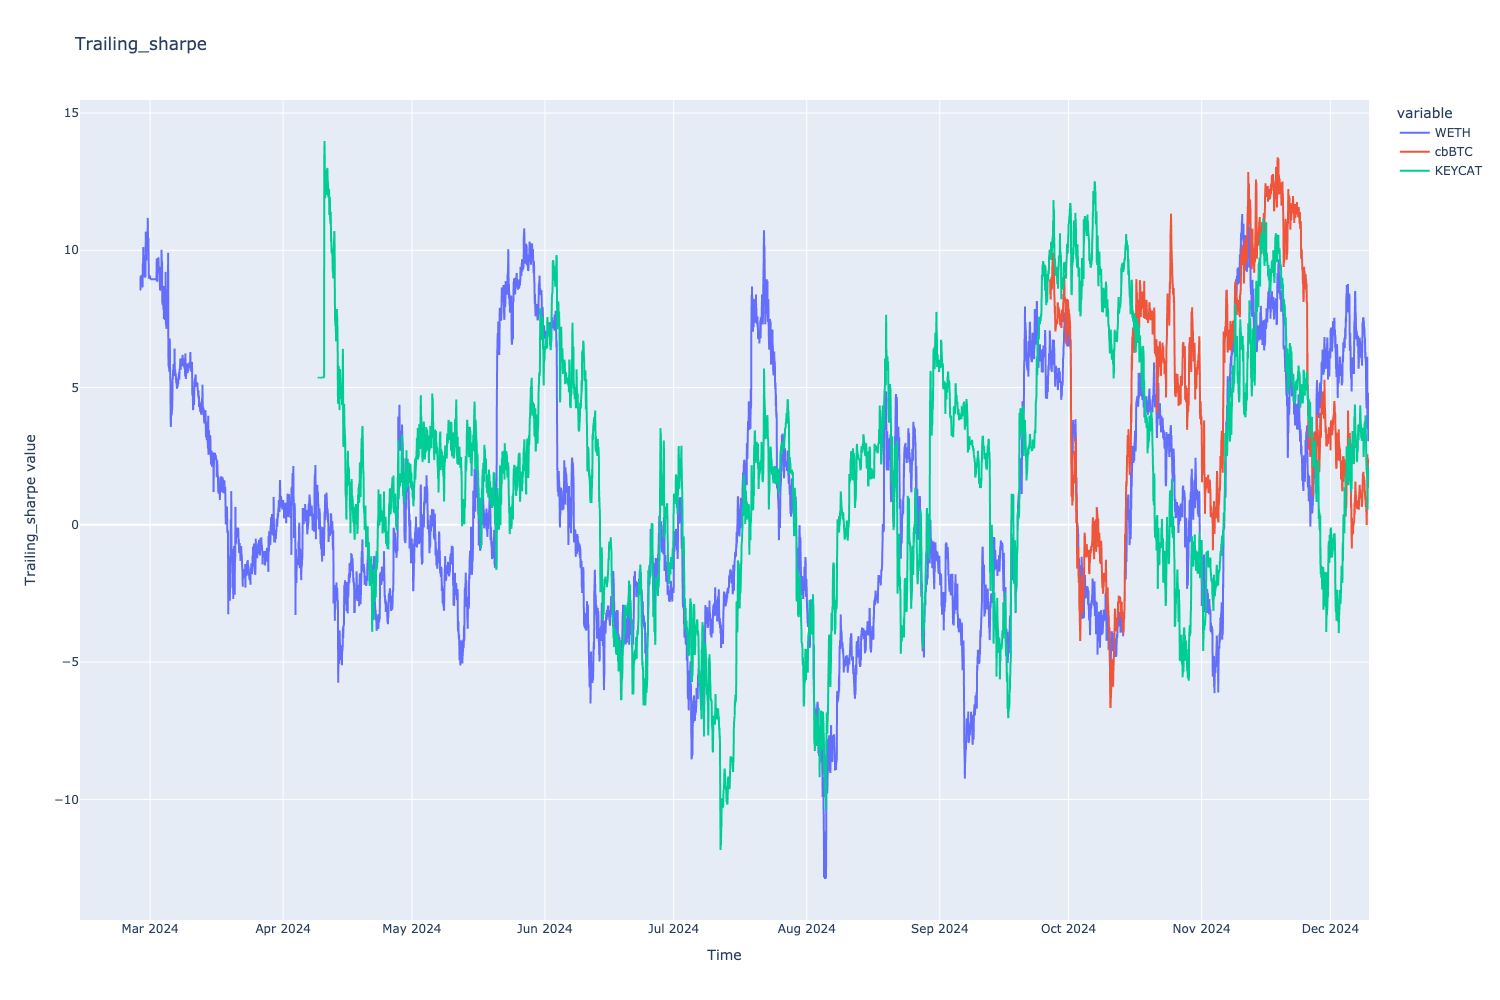

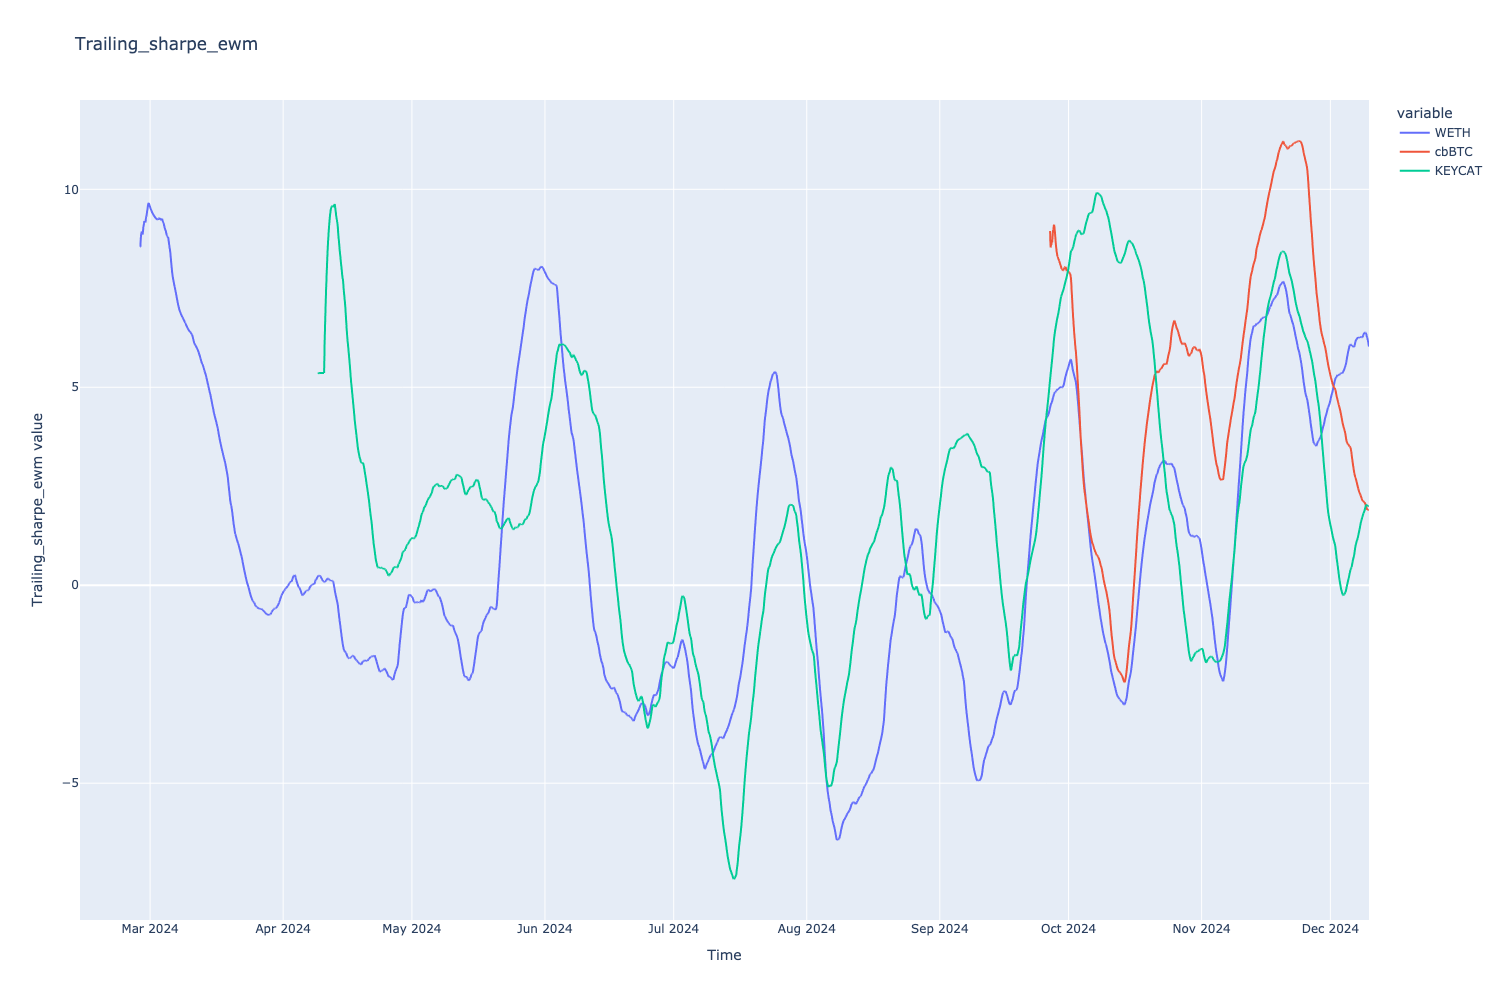

In [14]:
# Plot example indicators

import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT"]

checked_indicators = [
    "volatility", 
    "volatility_ewm", 
    "trailing_sharpe", 
    "trailing_sharpe_ewm", 
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# TVL data

- Examine TVL data of some pairs

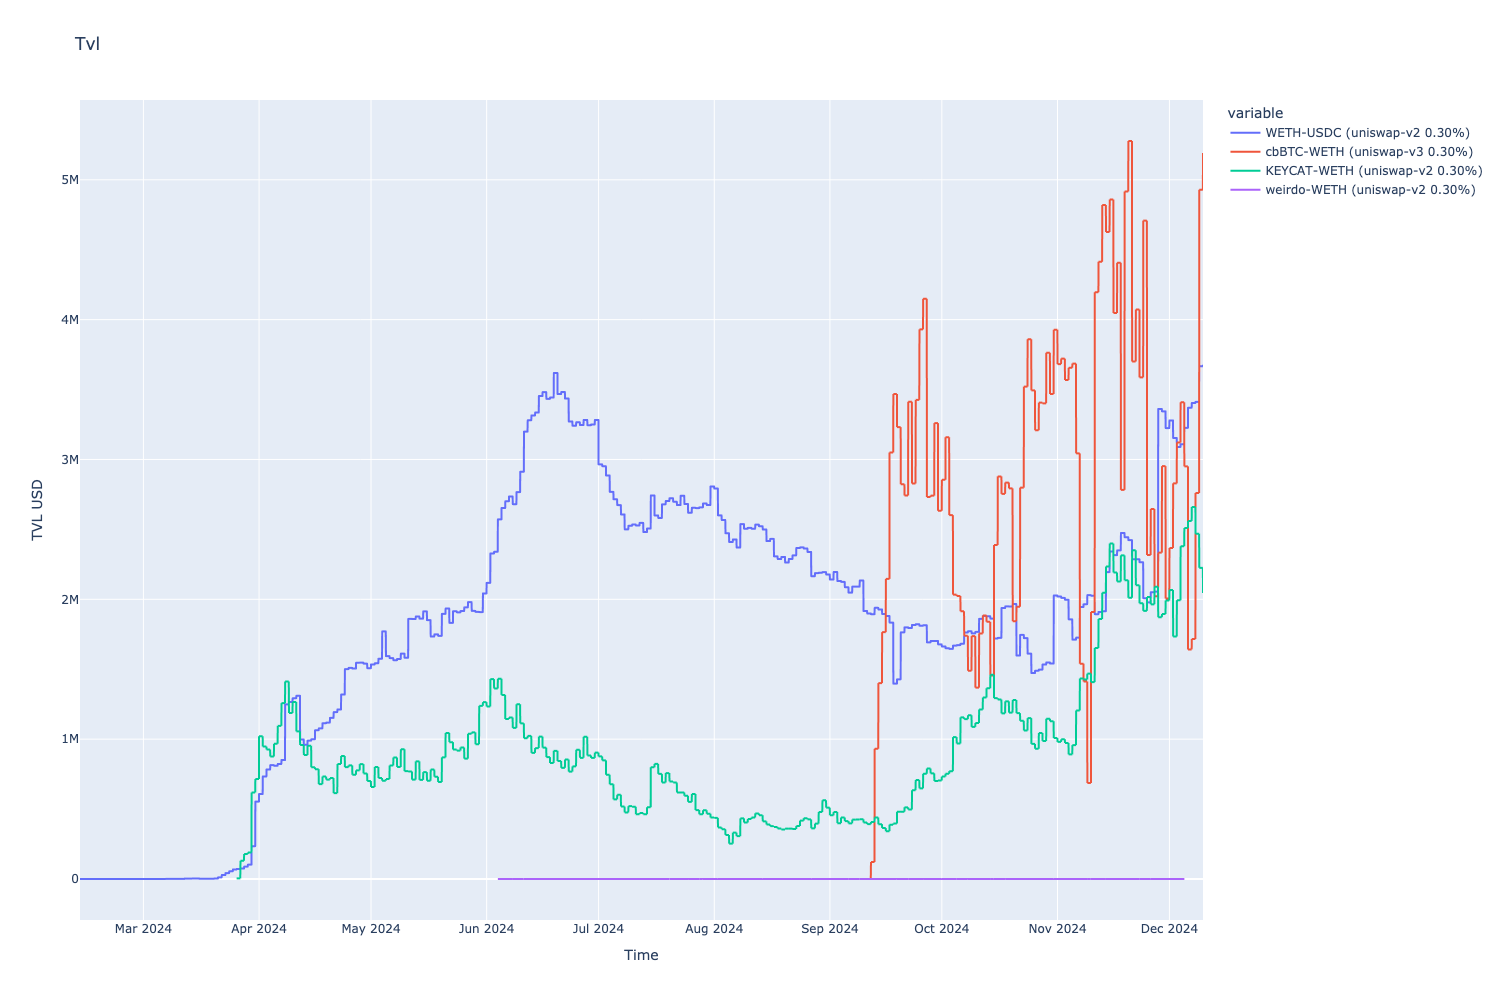

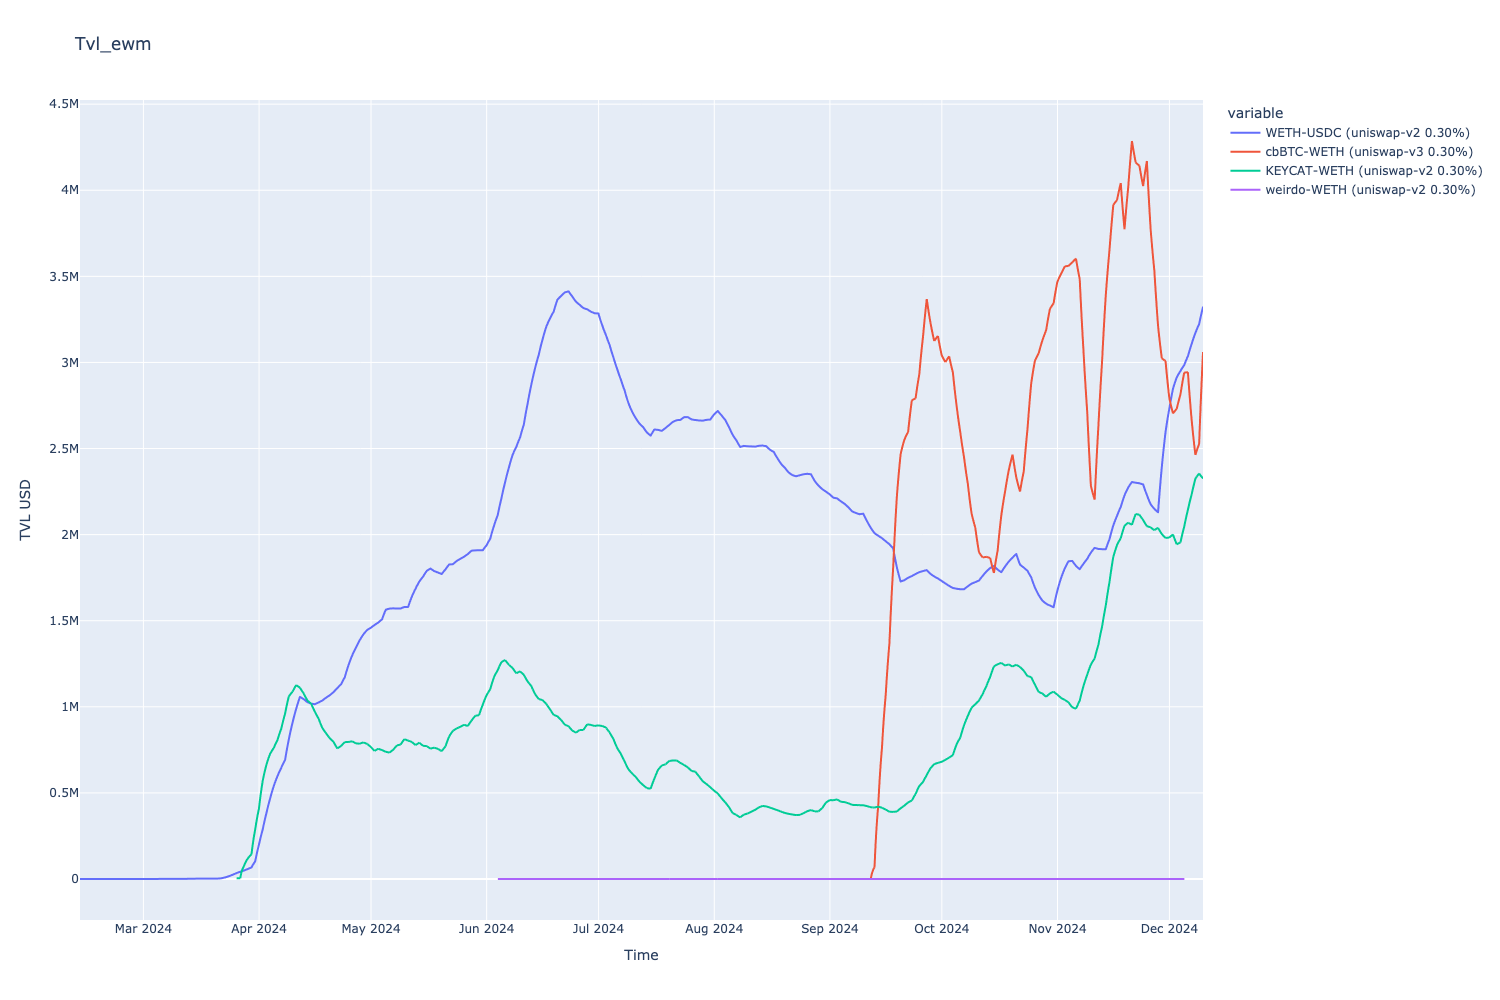

In [15]:
import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT", "weirdo"]
checked_indicators = ["tvl", "tvl_ewm"]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        label = f"{pair.get_ticker()} ({pair.exchange_name} {pair.fee:.2%})"
        data[label] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"TVL USD")
    fig.update_xaxes(title="Time")
    fig.show()

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

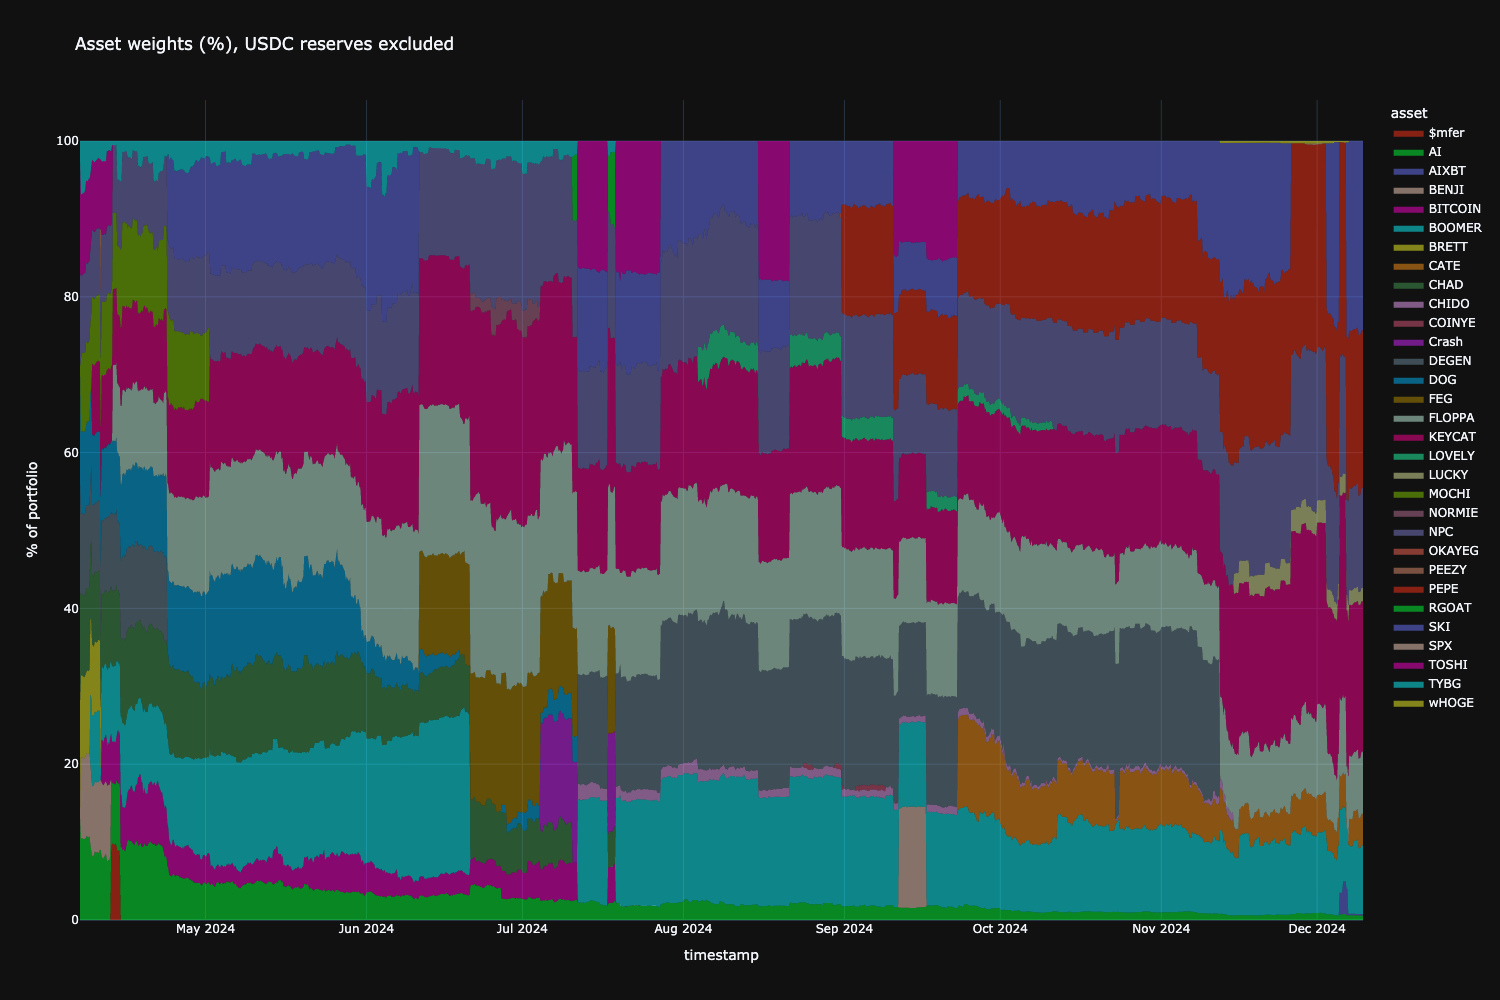

In [16]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

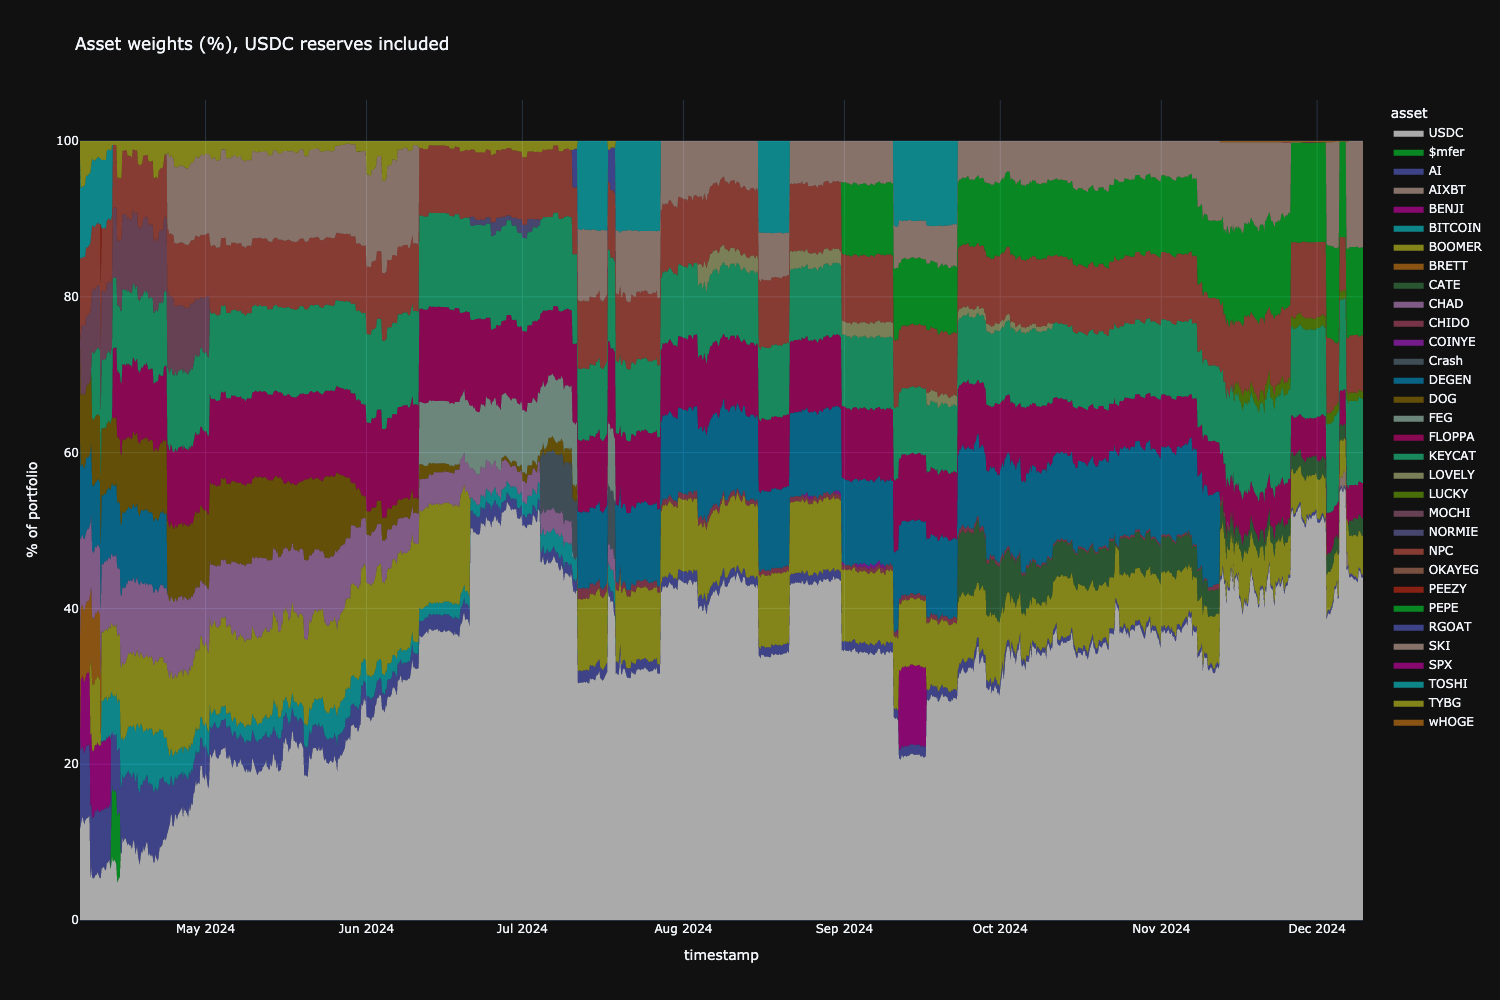

In [17]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

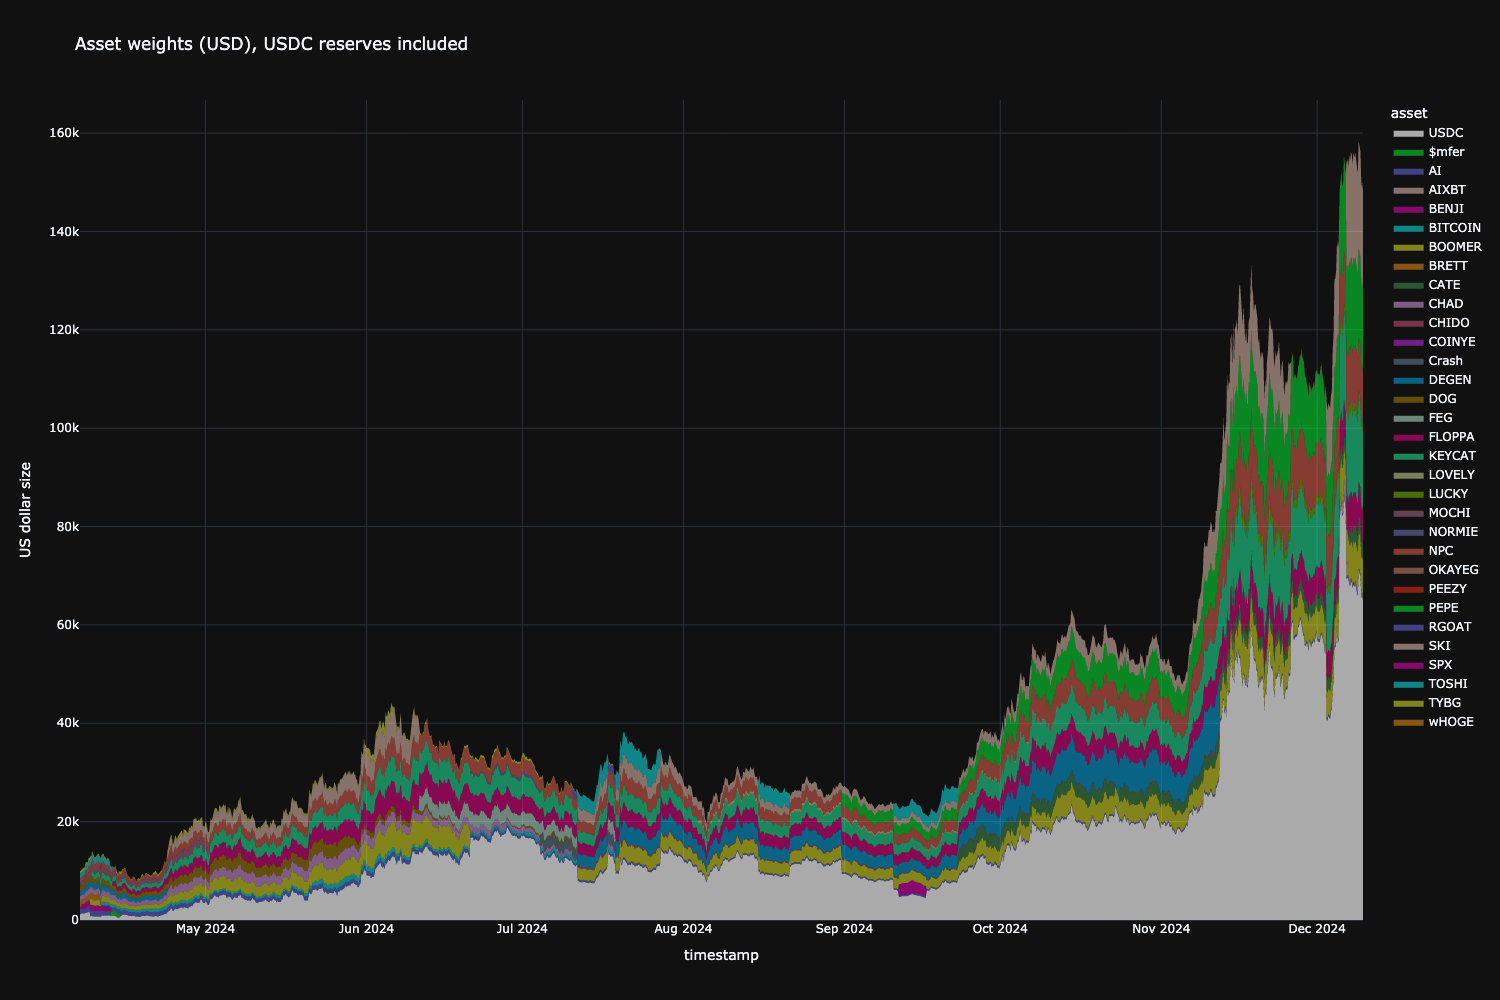

In [18]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [19]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


,At,Pair,Value,Unit
Name,,,,
Max position (excluding USDC),2024-12-09 00:00:00,SKI,"21,769.47",USD
Min position (excluding USDC),2024-04-13 20:00:00,TYBG,49.66,USD
Mean position (excluding USDC),,,"2,632.28",USD
Max position (excluding USDC),2024-11-27 16:00:00,PEPE,27.72,%
Min position (excluding USDC),2024-11-28 16:00:00,SPX,0.10,%
Mean position (excluding USDC),,,10.00,%
Max position (including USDC),2024-12-05 16:00:00,USDC,55.53,%
Min position (including USDC),2024-11-28 16:00:00,SPX,0.05,%
Mean position (including USDC),,,9.09,%


# Trading pair breakdown

- Trade success for each trading pair



In [20]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

,Trading pair,Positions,Trades,Total return %,Total PnL USD,Best,Worst,Avg,Median,Volume,Wins,Losses,Take profits,Stop losses,Trailing stop losses,Volatility
8,SKI-WETH spot,5,943,157.55%,"47,301.18",118.83%,-1.02%,31.51%,10.13%,"375,432.64",4,1,0,0,0,44.59%
4,BOOMER-WETH spot,4,1086,68.16%,"10,292.84",45.99%,0.03%,17.04%,11.07%,"223,077.63",4,0,0,0,0,17.83%
25,CHIDO-WETH spot,2,102,42.93%,"1,480.44",50.72%,-7.79%,21.47%,21.47%,"8,835.48",1,1,0,0,0,29.25%
5,PEPE-WETH spot,1,500,34.89%,"24,641.84",34.89%,34.89%,34.89%,34.89%,"148,894.02",1,0,0,0,0,0.00%
15,DEGEN-WETH spot,3,595,32.02%,"11,905.93",28.79%,-5.35%,10.67%,8.58%,"107,028.17",2,1,0,0,0,14.02%
13,TOSHI-WETH spot,5,147,22.86%,398.06,46.70%,-11.77%,4.57%,-7.85%,"40,884.20",2,3,0,0,0,21.86%
30,wHOGE-WETH spot,1,9,15.29%,40.30,15.29%,15.29%,15.29%,15.29%,567.47,1,0,0,0,0,0.00%
9,CATE-WETH spot,2,218,15.14%,699.00,13.49%,1.64%,7.57%,7.57%,"30,345.25",2,0,0,0,0,5.92%
3,FLOPPA-WETH spot,1,1202,13.67%,"17,509.12",13.67%,13.67%,13.67%,13.67%,"266,941.84",1,0,0,0,0,0.00%
2,KEYCAT-WETH spot,1,1238,12.82%,"21,264.80",12.82%,12.82%,12.82%,12.82%,"336,728.57",1,0,0,0,0,0.00%


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [21]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=["WETH", "KEYCAT", "ANDY"],
)

/Users/moo/code/trade-executor/tradeexecutor/analysis/multi_asset_benchmark.py:347: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Strategy,ETH,KEYCAT,ANDY
Start Period,2024-04-06,2024-04-06,2024-04-06,2024-04-06
End Period,2024-12-09,2024-12-09,2024-12-09,2024-12-09
Risk-Free Rate,0.0%,0.0%,0.0%,0.0%
Time in Market,100.0%,100.0%,99.0%,73.0%
Cumulative Return,"1,421.00%",18.75%,23.54%,-43.11%
CAGR﹪,1507.16%,19.16%,24.07%,-43.76%
Sharpe,3.51,0.71,1.8,0.52
Prob. Sharpe Ratio,99.94%,72.24%,94.05%,66.83%
Sortino,7.4,1.09,3.36,0.86
Sortino/√2,5.23,0.77,2.38,0.61


# Trading metrics

- Trading cost, etc.

In [22]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

,0
Trading period length,247 days 0 hours
Trading start,None
Trading end,None
Return %,1401.93%
Annualised return %,2071.67%
Cash at start,"$10,000.00"
Value at end,"$150,192.60"
Time in market,0.00%
Time in market volatile,0.00%
Trade volume,"$1,908,995.74"
